# Flow Processing Pipeline


## Goal of the pipeline

<font color=red> The goal of this notebook is to associate the raw ADT ground-data for 2013, 2015, 2017 and 2019, and the raw speed ground-data in 2015 to the Aimsun network for the calibration of Aimsun simulations. First the raw data is processed in a common format, then, every detector is associated with a network link inside Aimsun. Later, every detector is associated with a road section to create heatmap and understand the evolution of flows over years. </font>


### Outputs of the pipeline: 
- One file matching detectors location to Aimsun road section
- Two files with the processed flow data for 2013, 2015, 2017, 2019 (one for the city and one for PeMS)
- One file with the processed speed data for 2015
- One file with the flow data corresponding to road sections for 2013, 2015, 2017 and 2019
- PCA on flow data

### Inputs of the pipeline: 
**Raw data**
- PeMS account [_publicly available_]. Can be created in http://pems.dot.ca.gov
- PeMS detectors location [_publicly available_]. In the dropbox under `Demand/Flow_speed/Traffic\ flow\ studies/PeMS`
- City average annual daily traffic (AADT) data for 2013, 2017 and 2019 [_given by the city of Fremont_]. Located in the dropbox under `Demand/Flow_speed/Traffic\ flow\ studies/City`
- Kimley-Horn flow and speed data for 2015 [_given by the city of Fremont_]. Located in the dropbox under `Demand/Flow_speed/Traffic\ flow\ studies/Kimley\ Horn\ Data`

**Manually made dataset**
- Aimsun network
- Detectors location
- Road section layer
- Doc files or city ADT data corresponding to the PDF files
- Detectors ID to corresponding flow file name


### Temporary files of the pipeline
- CSV flow data
    - City and Kimley Horn
    - PeMS data
- geographic information of road detectors for 2013, 2015, 2017, 2019
- Flow_processed_tmp

### Dependent scripts: 
- [pems_download.py](https://github.com/Fremont-project/data-processing/blob/master/pipeline/flow/pems_download.py): the script automatically download PeMs data for chosen date.
- [pre_process_flow.py](https://github.com/Fremont-project/data-processing/blob/master/pipeline/flow/pre_process_flow.py): the script (A). parse the ADT data from xlsx, doc and csv files to csv files (B). Find the coordinates of the city detectors (C). Check and adjust the locations of the (City + PeMS) detectors to match them to our network using ArcGIS 
- [process_flow.py](https://github.com/Fremont-project/data-processing/blob/master/pipeline/flow/process_flow.py): this script processes all the flow traffic data into one big CSV file from both city and PeMS data files
- [process_years_together.py](https://github.com/Fremont-project/data-processing/blob/master/pipeline/flow/process_years_together.py): this script combines the previous scripts and processes the data for 2013, 2015, 2017, 2019
- [fremontdropbox](https://github.com/Fremont-project/data-processing/blob/master/fremontdropbox.py): 

### Dependent libraries:
- os
- sys
- webbrowser
- time
- requests
- pathlib.Path
- textract
- [numpy](https://numpy.org)
- datetime
- pandas
- math
- requests
- glob
- csv
- re
- Rtree (needs spatialindex, brew install spatialindex)
- osmnx
- keplergl
- shapely

### Work done by the script
1. Obtaining Data
    - Turn city pdf to doc
    - PeMS data download
2. Preprocessing city and Kimley-Horn data
    - Parsing the flow data [We are here]
    - Parsing the speed data
    - Geocoding location of the detectors
    - Manually update the location of the detectors
3. Processing the data
    - Creating one file with the flow for all detectors
    - Creating a layer of road section
    - Matching the detectors to road section
    - Creating one file with the flow over time for every road section
    - Matching the detectors with the corresponding road section in Aimsun
4. Exporting the data
    - Exporting a csv file where Aimsun road sections are matched with detectors
    - Exporting a csv file with flow for the different road sections
    - Exporting traffic flow heatmap
    - Exporting speed heatmap
    - PCA on the traffic flow heatmap over years

# <font color=red> TO DO: </font>
- <font color=green> Jiayi, put the to dos in green when done </font>, <font color=blue> in blue if you need some help </font>, <font color=red>put them red if you have not done them yet</font>
- <font color=green> should have exception handler in the process (and python function) if the files are not located where you are looking for.</font>
- run PCA and create heatmap with ArcGIS (heatmap will be done by Theo)
- <font color=red> Put the scripts together in one main script </font>
- <font color=red> add link from work done by the script to section of the iPython notebook </font>
- write tests for detectors shapefiles/

In [3]:
import sys
import os

# We let this notebook to know where to look for fremontdropbox module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from fremontdropbox import get_dropbox_location

dropbox_dir = get_dropbox_location()



## 1. Obtaining Data

### A) PeMS Data Download 
    
Script: pems_download.py <br>
Download traffic data from the PEMS website (pews.dot.ca.gov) for years 2013, 2015, 2017 and 2019 <br>

We download the data calling the method download(detector_ids, year, PeMS_dir) from the pems_download.py file. The process takes about 20 minutes to run. 
Run `print(help(pems.download))` to get some help.

### B) Turn city pdf to doc

Some of the flow data that we got from the city were in pdf files. To be able to parse them, we convert them to doc files using online website. This should be done before running the code. The doc files are inputs of the pipeline.

In [1]:
import pems_download as pems
print(help(pems.download))

Help on function download in module pems_download:

download(year, detector_ids, PeMS_dir)
    This function downloads traffic data from the PeMS website (pems.dot.ca.gov).
    This function has for input:
        - PeMS detectors ID: detector_ids (an array of detectors)
        - Year for the desired data: year (one year as a integer, should be 2013, 2015, 2017 or 2019)
    
    This function has for output:
        - All corresponding PeMS detectors data file for the given year (and the given days encoded in the url).
        - Stored in the download folder as PeMS_dir/PeMS_year/PeMS-ID_YEAR.xlsx (where PeMS-ID is the detector ID given by PeMS).
        One xlsx file has two sheets:
            - PeMS Report Description
            - Report Data
                - Contains the traffic flow data
                - Each row gives the number of vehicles observed in one time step (5 minutes) per lane number over the columns.
                - The first column gives the date and time stamp,

In [4]:
# ************* IMPORTANT *************
# --> For this cell to work, you need to log in to PeMS in the same browser that runs this Jupyter notebook

## The IDs of the PeMS detectors where obtained using ArcGIS software and an input file, pems_detectors.csv, containing the locations of all the PeMS dectectors in California
## this should be done in Python!
detector_ids = [403250, 403256, 403255, 403257, 418387, 418388, 400376,
               413981, 413980, 413982, 402794, 413983, 413984, 413985,
               413987, 413986, 402796, 413988, 402799, 403251, 403710,
               403254, 403719, 400566, 418420, 418419, 418422, 418423,
               402793, 403226, 414015, 414016, 402795, 402797, 414011,
               402798]
PeMS_dir = dropbox_dir + '/Private Structured data collection/Data processing/Auxiliary files/Demand/Flow_speed/PeMS'

# pems.download(2013, detector_ids, PeMS_dir)
# pems.download(2015, detector_ids, PeMS_dir)
# pems.download(2017, detector_ids, PeMS_dir)
# pems.download(2019, detector_ids, PeMS_dir)

# TO DO Later:
- Find the list of detectors ID using the project delimitation shapefile. (to be done later)

In [5]:
pems.PeMS_tester(2013, PeMS_dir, True)
pems.PeMS_tester(2015, PeMS_dir, True)
pems.PeMS_tester(2017, PeMS_dir, True)
pems.PeMS_tester(2019, PeMS_dir, True)

PeMS during 03/05/2013 00:00:00-03/07/2013 23:59:59
PeMS during 03/03/2015 00:00:00-03/05/2015 23:59:59
PeMS during 03/07/2017 00:00:00-03/09/2017 23:59:59
PeMS during 03/05/2019 00:00:00-03/07/2019 23:59:59


## 2. Parsing city data


### A) Parse city and Kimley Horn flow data from xlsx, doc and csv files to csv files

Here, we process the Excel and PDF ADT data files (city data) into CSV files.

- run `print(help(pre_process.parse_excel_2013)` to get some help for 2013 excel files
- run `print(help(pre_process.parse_excel_2015)` to get some help for 2015 excel files
- run `print(help(pre_process.parse_excel_2017)` to get some help for 2017 excel files
- run `print(help(pre_process.parse_excel_2019)` to get some help for 2019 excel files
- run `print(help(pre_process.parse_adt_as_file)` to get some help for the 2017 and 2019 doc files

In [6]:
import pre_process_flow as pre_process
print(help(pre_process.process_adt_data))

Help on function process_adt_data in module pre_process_flow:

process_adt_data(year, Processed_dir, Input_dir)
    This function processes the Excel and PDF ADT data files (city data) into CSV files. Note that one file corresponds to one main road and the traffic flow data recordings in it.
    
    This function has input:
        - year which takes values 2013, 2015, 2017 or 2019
        - Processed_dir: path to the output
        - Input_dir: path to the inputs
    
    The function has output:
        - CSV files located in the Processed_dir/Year_processed/ folder where Year=2017 or 2019
    
    For the function to work:
        - Files should be located in 
            1. Input_dir/Year\ EXT/ folder if Year=2013, 2017 or 2019 where:
                a. Year=2013, 2017 or 2019 if Ext=ADT Data 
                b. Year=2017 or 2019 if Ext=doc for 2017 and 2019
            2. Input_dir/Raw\ data/ folder if Year=2015

None


In [7]:
print(help(pre_process.parse_excel_2013))
print(help(pre_process.parse_excel_2015))
print(help(pre_process.parse_excel_2017))
print(help(pre_process.parse_excel_2019))
print(help(pre_process.parse_adt_as_file))

Help on function parse_excel_2013 in module pre_process_flow:

parse_excel_2013(dfs)
    ***2013 Excel files*** are structured in data sheets. The first data sheet "Summary" contains the main road, cross streets, city information and the start date of the recording. It also summarizes the data contained in all other sheets into a bar plot of traffic flow vs time of day bins (i.e Tuesday AM, Wednesday PM) for different flow directions and into a line plot of traffic flow vs. hour of day for different days of the week. The sheets that follow are named "D1", "D2",..."DN" where N denotes the N'th day since the start date. These sheets are structured into two tables, AM counts and PM counts. Each table row gives the traffic flow per timestep of 15 minutes. The first column is the time of day in hh:mm format follow by direction columns of traffic flow (NB, SB, EB, WB).

None
Help on function parse_excel_2015 in module pre_process_flow:

parse_excel_2015(dfs)
    ***2015 Excel files***. The f

# <font color=red> TO DO: </font>
- <font color=green> Re do the parsing such that all the files look the same. The time format should be the same everywhere.
- Remove the unnecessary functions in pre_process
- <font color=green> Write test to check if the parsing of doc file is correct

In [9]:
ADT_dir = dropbox_dir + '/Private Structured data collection/Data processing/Raw/Demand/Flow_speed'
Processed_dir = dropbox_dir + '/Private Structured data collection/Data processing/Auxiliary files/Demand/Flow_speed/Flow_processed'
City_dir = ADT_dir + "/City"
Kimley_Horn_flow_dir = ADT_dir + "/Kimley Horn Data"
local_testing = '/Users/LiJiayi/Documents'

# pre_process.process_adt_data(2013, Processed_dir, City_dir)
# pre_process.process_adt_data(2015, Processed_dir, Kimley_Horn_flow_dir)
# pre_process.process_adt_data(2017, Processed_dir, City_dir)
# pre_process.process_adt_data(2019, Processed_dir, City_dir)


In [10]:
#test the elibility of the doc files in 2017 and 2019. 
pre_process.doc_file_tester(City_dir, [2017, 2019])

Doc files are all good for both 2017 and 2019!



### B) Find the coordinates of the city detectors
We obtained the coordinates of the detectors by calling the method get_geo_data(year) from the pre_process.py python file. 

- run `print(help(pre_process.get_geo_data))` to get some help.

# <font color=red> TO DO Theo: </font>
- Check the directions and how the files should look like. Think about the IDs.
- Once Jiayi has done the merge of process_tmp and process_city, work on get_geo_data to have the same IDs.
- Work on the shapefile to correct the IDs of the detectors.
- Write a test function to compare the detectors shapefiles ID to the ID of process_city
- <font color=green>Put the different files year_info.csv together, and compare it to the [google doc] (Done)(https://docs.google.com/spreadsheets/d/1tcps-8aorPZLY8nswnNCmjWSJi-7ey8Ps4twWFz2ls0/edit#gid=0) </font>
- <font color=green> Make sure to process doc files (Done) </font>
- <font color=green> Make sure to process PeMS files too (for this ask Theo)</font>
- <font color=blue> Then we want to match the detectors to the ID associated to them here.</font>

In [11]:
print(help(pre_process.get_geo_data))

Help on function get_geo_data in module pre_process_flow:

get_geo_data(year, Input_dir, Processed_dir)
    This function iterates over the ADT files and obtains the adresses of the detectors to then use with Google API to obtain latitude and longitude coordinates.
    
    This function has input:
        - Year takes values 2013, 2015, 2017, 2019
        - Processed_dir: path to the output
        - Input_dir: path to the inputs
    
    This function has output:
        - CSV file "year_info_coor.csv" containing the coordinates of detectors and located in the Processed_dir/Year_processed/ folder where Year=2017 or 2019
    
    For the function to work:
        - Files should be located in 
            1. Input_dir/Year\ EXT/ folder if Year=2013, 2017 or 2019 where:
                a. Year=2013, 2017 or 2019 if Ext=ADT Data 
                b. Year=2017 or 2019 if Ext=doc for 2017 and 2019
            2. Input_dir/Raw\ data/ folder if Year=2015 
    
    + add the doc files

None


In [ ]:
pre_process.get_geo_data(2013, City_dir, Processed_dir)
pre_process.get_geo_data(2015, Kimley_Horn_flow_dir, Processed_dir)
pre_process.get_geo_data(2017, City_dir, Processed_dir)
pre_process.get_geo_data(2019, City_dir, Processed_dir)

In [ ]:
City_dir = ADT_dir + "/City"
Kimley_Horn_flow_dir = ADT_dir + "/Kimley Horn Data"

In [ ]:
# Preprocess 2015 speed data
pre_process.Speed_data_parser(Kimley_Horn_flow_dir, Processed_dir)

# To do
- process the flow to flow_processed_city (the funtion `process_flow.process_data_City(Processed_dir, re_formated_Processed_dir)` in the function `pre_process.flow_processed_generater(Processed_dir)` so you do not assign two ids to one same detector.
- make sure the ids of the speed match the id of the flow.



In [ ]:
# summary files generater:

pre_process.google_doc_generater(Processed_dir)
pre_process.flow_processed_generater(Processed_dir)


# Theo: I am here

### C) Check and adjust the locations of the (City + PeMS) detectors to match them to our network using ArcGIS <br>
Done in the software manually in ArcGIS.
1. Export Aimsun network as GIS file
2. Import Aimsun network in ArcGIS
3. Import detectors in ArcGIS as XY_points
4. Move detectors to put them on corresponding road in Aimsun
5. Associate to every detectors the External ID of the Aimsun road (to be done again)

**TO DO THEO**: Add the process to create the detectors inside Aimsun.
Add the process to match the detectors to road section (and create the file lines_to_detectors.xlsx


### Later to do: do the spatial join in python

### 3. Process Data

In [ ]:
from pathlib import Path

ADT_dir = dropbox_dir + '/Private Structured data collection/Data processing/Raw/Demand/Flow_speed/ADT'
PeMs_dir = dropbox_dir + '/Private Structured data collection/Data processing/Auxiliary files/Demand/Flow_speed/PeMs'
local_download =  str(os.path.join(Path.home(), "Downloads"))
re_formated_Processed_dir = dropbox_dir + '/Private Structured data collection/Data processing/Temporary exports to be copied to processed data/Flow_processed'



# <font color=red> TO DO: </font>
- <font color=green> Create the file Flow_processed_tmp.csv from year_info.csv to check if everything is fine [Done]</font>
- <font color=green> Rename the file Flow_processed_tmp.csv -> detectors_id.csv and put it in the manually made dataset [Partially done] </font>
- <font color=blue> Merge flow_processed_city.csv and flow_processed_PeMS.csv together in the function </font> 
- <font color=red> Go over Zixuan code to make the code in process_flow better </font>
- <font color=green>Processs speed data for 2015 </font>

### A) Process the csv files (city + caltrans) to one big file. <br>
source code: processing flow to one CSV.ipynb <br>

We combine all the flow traffic data into one big CSV file from both city and PeMS data files. This is done by calling the function process_data() from the process_flow.py python file. 

Description of function process_data()
<br>
The function has input:
- "Flow_processed_tmp.csv" file that lists all the processed files from city and PeMS data
- The processed files created from the Parsing Data section

The function has output:
- "Flow_processed_city.csv" containing combined city flow data for all year
- "Flow_processed_PeMS.csv" containing combined PeMS flow data for all years

For the function to work:
- The processed files (input) must be located in City and PeMs folders
- 2013 city processed files are located in "City/2013 reformat/"
- 2017 and 2019 city processed files that originated from DOC (which originated from PDF) files are located in "City/Year reformat/Format from pdf" folder where Year=2017 or 2019
- 2017 and 2019 city processed files that originated from Excel files are located in "City/Year reformat/Format from xlsx" folder where Year=2017 or 2019
- 2013, 2017 and 2019 PeMS data files are located in "PeMS_Year" folder where Year=2013, 2017 or 2019

For the pipeline to work:
- The ouput files must remain in the working directory, no moving necessary.

Structure of ouput files: 
- Flow_processed_city.csv
    - contains city traffic data where the rows represent traffic flow. The first 5 columns give info about the traffic flow and are Year, Name, Id, Direction, Day 1 where Name refers to the file name from which the data originated, Id is the Id from the "Flow_processed_tmp.csv" file, Direction is the direction of flow and Day 1 is the start date of recording. The columns that follow are day-timesteps for flow data. There are 3 days total over which traffic flow is recorded and time progresses in 15 minute steps. Hence the data columns progress as "Day 1 - 0:0", "Day 1 - 0:15", "Day 1 - 0:30",...,"Day 3 - 23:30", "Day 3 - 23:45".
- Flow_processed_PeMS.csv
    - contains PeMS flow traffic data where the rows represent traffic flow. The first columns are Name, Id and Name PeMS where Name contains the PeMS detector Id, Id is the Id assigned from "Flow_processed_tmp.csv", Name PeMs is the road address. The next 6 columns give Observed Year and Day Year for the 3 years, 2013, 2017 and 2019. Observed Year is the percentage of the observed data and Day Year is the start date of recording. The columns that follow are Year-Day-timestep, there are 3 years, 3 days and time progresses in 15 minute steps. Hence the columns progress as "2013-Day 1 - 0:0", "2013-Day 1 - 0:15", "2013-Day 1 - 0:30",...,"2019-Day 3 - 23:30", "2019-Day 3 - 23:45".

**(DONE) TO DO 8**: Explain the structure of the output files. Also, feel free to document the doc in the python file (or iPython file). Explain also the input (Flow_processed_tmp.csv) and how it was created (I think it was created from the google doc https://docs.google.com/spreadsheets/d/1tcps-8aorPZLY8nswnNCmjWSJi-7ey8Ps4twWFz2ls0/edit#gid=0).

***Edson Question***: the Flow_processed_tmp.csv file and the google doc seem the same to me (except for the lat, lng info on the right side of the google doc). Beyond this, I don't know how the file was created. Who to ask for more info?

***Theo Answer***: I guess I have created the file from the google doc. But I have also created the google doc during the parsing. Probably in 2) we can create Flow_processed_tmp.csv from year_info.csv



In [ ]:
import process_flow as pf

pf.process_data_City(Processed_dir, re_formated_Processed_dir)
pf.proces_data_PeMS(Processed_dir, re_formated_Processed_dir, PeMS_dir)


#pf.process_data(Processed_dir, re_formated_Processed_dir, PeMs_dir)

### B) Create file that gives traffic flows for specific road sections for every year. <br>
source note: put years together.ipynb

- Use detectors (lines_to_detectors.csv) and flow processed city (flow_processed_city.csv) data to create all years flow data in "flow_processed_section.csv"


# To do 9: the function pytogether should be written again. + add 2015
- add the PeMS data
- be more clever about missing data or road section associated with several detectors (take the average)

### To do later, do the spatial join in python

In [ ]:
import process_years_together as pytogether

line_to_detectors = re_formated_Processed_dir + '/lines_to_detectors.csv'
flow_processed_city = re_formated_Processed_dir + '/Flow_processed_city.csv'
pytogether.run(line_to_detectors, flow_processed_city)

### 4. Data Analysis

A) PCA

B) Analyse PCA results using heatmap inside ArcGIS

In [4]:
data_process_folder = dropbox_dir + "/Private Structured data collection/Data processing/"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

creating detectors_to_road_segments_2013.csv
number of road segments 7373
number of detectors 59

creating detectors_to_road_segments_2015.csv
number of road segments 7373
number of detectors 30

creating detectors_to_road_segments_2017.csv
number of road segments 7373
number of detectors 56

Detector without a road segment assigned, with search radius of 0.03
Detector_Id                                          73
geometry       POINT (-121.999638639 37.53287566100005)
Name: 8, dtype: object

Detector without a road segment assigned, with search radius of 0.03
Detector_Id                                        74
geometry       POINT (-121.9996784 37.53283362000008)
Name: 9, dtype: object

creating detectors_to_road_segments_2019.csv
number of road segments 7373
number of detectors 56

creating detectors_to_road_segments_pems.csv
number of road segments 7373
number of detectors 36

Finding detecto

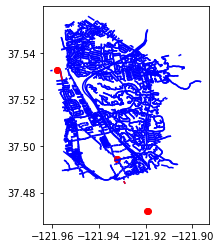


Finding detector to road duplicates for 2015
No duplicates found

Finding detector to road duplicates for 2017

found multiple detectors for road id 12876

detector 0 info:
Detector_Id       93.000000
eid            12876.000000
Distance           0.015572
Name: 28, dtype: float64

detector 1 info:
Detector_Id       94.000000
eid            12876.000000
Distance           0.015604
Name: 29, dtype: float64

Duplicates written to duplicates_2017.csv


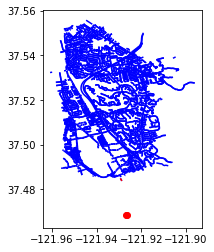


Finding detector to road duplicates for 2019
No duplicates found

Finding detector to road duplicates for pems

found multiple detectors for road id 8111

detector 0 info:
Detector_Id    413985.000000
eid              8111.000000
Distance            0.000001
Name: 13, dtype: float64

detector 1 info:
Detector_Id    402796.000000
eid              8111.000000
Distance            0.000004
Name: 16, dtype: float64

found multiple detectors for road id 6507

detector 0 info:
Detector_Id    403710.000000
eid              6507.000000
Distance            0.000001
Name: 20, dtype: float64

detector 1 info:
Detector_Id    418419.000000
eid              6507.000000
Distance            0.000008
Name: 25, dtype: float64

found multiple detectors for road id 8132

detector 0 info:
Detector_Id    418422.000000
eid              8132.000000
Distance            0.000051
Name: 26, dtype: float64

detector 1 info:
Detector_Id    402793.000000
eid              8132.000000
Distance            0.000051
Name

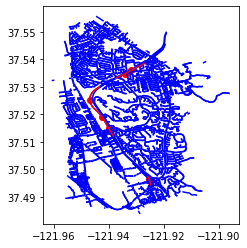

In [14]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plot
from shapely import wkt
# import keplergl as kp
import spatial_join as sj

%load_ext autoreload
%autoreload 2

# # directories to detectors and aimsum sections shape files
# # start from current working directory (ie. same folder as notebook)
data_process_folder = dropbox_dir + "/Private Structured data collection/Data processing/"
detectors_folder = data_process_folder + "Raw/Demand/Flow_speed/detectors/"
section_folder = data_process_folder + "Raw/Network/Aimsun/"
output_folder = data_process_folder + "Temporary exports to be copied to processed data/Network/Infrastructure/Detector/"

# find closest road segment for each detector
# results written to a csv per year named: detetctors_to_road_segments_year.csv
sj.detectors_to_road_segments(2013, sections_folder, detectors_folder, output_folder)
sj.detectors_to_road_segments(2015, sections_folder, detectors_folder, output_folder)
sj.detectors_to_road_segments(2017, sections_folder, detectors_folder, output_folder)
sj.detectors_to_road_segments(2019, sections_folder, detectors_folder, output_folder)
sj.detectors_to_road_segments('pems', sections_folder, detectors_folder, output_folder)

# # Find duplicates. That is, multiple detectors are closest to one road, if any.
# # results if any written to a csv per year named: duplicates_year.csv
sj.find_duplicates(2013, sections_folder, detectors_folder, output_folder, show_plot=True)
sj.find_duplicates(2015, sections_folder, detectors_folder, output_folder, show_plot=True)
sj.find_duplicates(2017, sections_folder, detectors_folder, output_folder, show_plot=True)
sj.find_duplicates(2019, sections_folder, detectors_folder, output_folder, show_plot=True)
sj.find_duplicates('pems', sections_folder, detectors_folder, output_folder, show_plot=True)

# kepler_map = sj.create_kepler_map(sections_folder, detectors_folder)
# kepler_map

### Edson Tasks Done (0-2)
Additionally, library dependent files were added on top. They are:
- Rtree (needs spatialindex, brew install spatialindex)
- osmnx
- keplergl
- shapely

In [11]:
import spatial_join as sj
import process_years_together2 as pyt

# Task 0
# Formatted output files, detectors_to_road_segments_year.csv were sent to Su for all years and pems.

# Task 1
data_process_folder = dropbox_dir + "/Private Structured data collection/Data processing/"
streetline_folder = data_process_folder + "Raw/Demand/Flow_speed/Road section/"
detectors_folder = data_process_folder + "Raw/Demand/Flow_speed/detectors/"
output_folder = data_process_folder + "Temporary exports to be copied to processed data/Network/Infrastructure/Detector/"

# Create lines_to_detectors.csv in output_folder
sj.streetlines_to_detectors(streetline_folder, detectors_folder, output_folder)    

# Task 2
flow_processed_all_folder = data_process_folder + "Auxiliary files/Demand/Flow_speed/Flow_processed/"

# Create flow_processed_section.csv using lines_to_detectors.csv and Flow_processed_all.csv
pyt.create_flow_processed_section(output_folder, flow_processed_all_folder, output_folder)


# To do Edson
0. Make sure to have the output of the detectors spatial join on the road section of Aimsun in the correct format.
See Aimsun team for that.

1. Create line to detectors with Geopandas
Join spatial the detectors to the closest road section in streetline shapefile in street_line_folder and create the doc line_to_detectors.csv where the headings is:
OBJECTID, Shape_Length, Name, Direction, 2013, 2015, 2017, 2019, PeMS

One row = one road section of the streetline shapefile with the corresponding id of the closest detectors for 2013, 2015, 2017, 2019 or PeMS detectors.
One road section can be matched to several detectors (or no detectors).

2. Create the flow_processed_section.csv 
This has been partially done in put years together.ipynb.
One row = one road section
One column = the data at one time step of 15 minutes for one specific year and one specific day and one specific time step.
Create the file using both the line_to_detectors.csv file created in 1 and the process_flow_city.csv and process_flow_pems.csv in auxilary_folder.

3. Ask Theo to do the PCA
See the PCA notebook.
Visualization with Kepler.gl

4. Ask Theo to test the different work done so far
Compare the resutls of the different spatial joins to manually made spatial join in ArcGIS. Both for detectors to Aimsun and detectors to street line.

5. Learn how to modify a shapefile in order to change the IDs of the detectors in the shapefile
Reorder the IDs of the detectors to have 2013, 2015, 2017 and 2019.

6. List of PeMS detectors using project delimitation shapefile

7. Internal centroids connections creation with geopandas in the demand pipeline